# Training Deep Neural Networks

Training a deep neural network comes with some problems that one can run into:

- Tricky `vanishing gradients problem` or the related `exploding gradients problem`. This is when the gradients grow smaller and smaller, or larger and larger, when flowing backward through the DNN during training. Both of these problems make lower layers very hard to train.

- Not having enough training data for such a large network, or it might be too costly to label.

- Training may be extremely slow.

- A model with millions of parameters would severely risk overfitting the training set, especially if there are not enough training instances or if they are too noisy.

In this chapter we will go through each of these problems and present techniques to solve them.

## The Vanishing/Exploding Gradients Problems

gradients often get smaller and smaller as the algorithm progresses down to the lower layers. As a result, the `Gradient Descent` update leaves the lower layers’ connection weights virtually unchanged, and training never converges to a good solution. This is called the `vanishing gradients problem`. In some cases, the opposite can happen: the gradients can grow bigger and bigger until layers get insanely large weight updates and the algorithm diverges. This is the `exploding gradients problem`, which surfaces most often in `recurrent neural networks`. More generally, deep neural networks suffer from *unstable gradients*; different layers may learn at widely different speeds.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

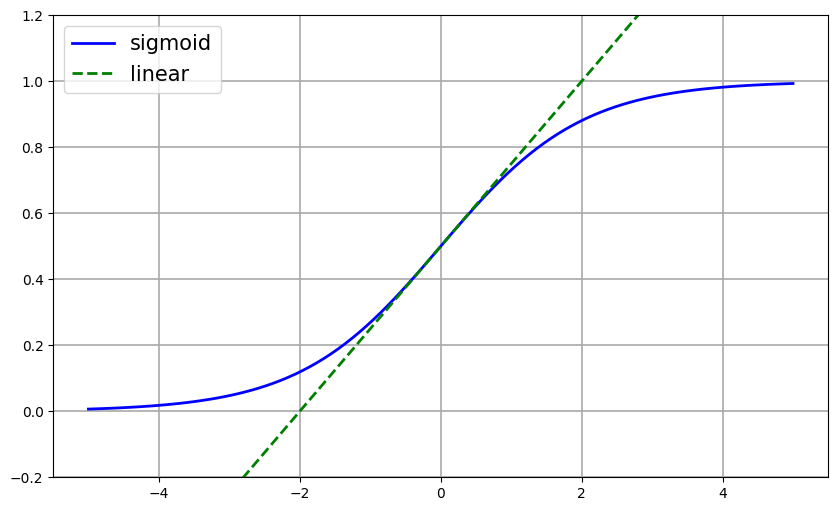

In [2]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# plot sigmoid

z = np.linspace(-5, 5, 100)

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(z, sigmoid(z), color='blue', linestyle='-', label='sigmoid', linewidth=2)
ax.plot(z, 1/2 + z/4, color='green', linestyle='--', label='linear', linewidth=2)

ax.grid(linewidth=1.2, color='darkgrey')
ax.legend(fontsize=15)

plt.ylim(-0.2, 1.2)

plt.show()

Looking at the `sigmoid` ($ \mathbf{sigmoid} (z) = 1 / (1+e^{-z})$) activation function above, we can see that when inputs become large (negative or positive), the function saturates at $0$ or $1$, with a derivative extremely close to $0$ (i.e., the curve is almost flat at both extremes). Thus, when backpropagation kicks in it has virtually no gradient to propagate back through the network; and what little gradient exists keeps getting diluted as backpropagation progresses down through the top layers, so there is really nothing left for the lower layers.

### Glorot and He Initialization

**Glorot initialization (when using the sigmoid activation function):**
$$ \text{Normal distribution with mean } 0 \text{ and variance } \sigma^2 = \frac{1}{fan_{\mathbf{avg}}} $$
$$ \text{Uniform distribution between } -r \text{ and } r, \text{ with } r = \sqrt{\frac{3}{fan_{\mathbf{avg}}}} $$
where $fan_{\mathbf{avg}} = (fan_{\mathbf{in}} + fan_{\mathbf{out}})/2$. This initialization strategy is called `Xavier initialization` or `Glorot initialization`. 

Some papers⁠ have provided similar strategies for different activation functions. These strategies differ only by the scale of the variance and whether they use $fan_{\mathbf{avg}}$ or $fan_{\mathbf{in}}$, as shown in the Table (for the uniform distribution, use $ r = \sqrt{3\sigma^2}$). The initialization strategy for the `ReLU` activation function and its variants is called `He initialization` or `Kaiming initialization`. For `SELU`, use `Yann LeCun`’s initialization method, preferably with a Normal distribution.

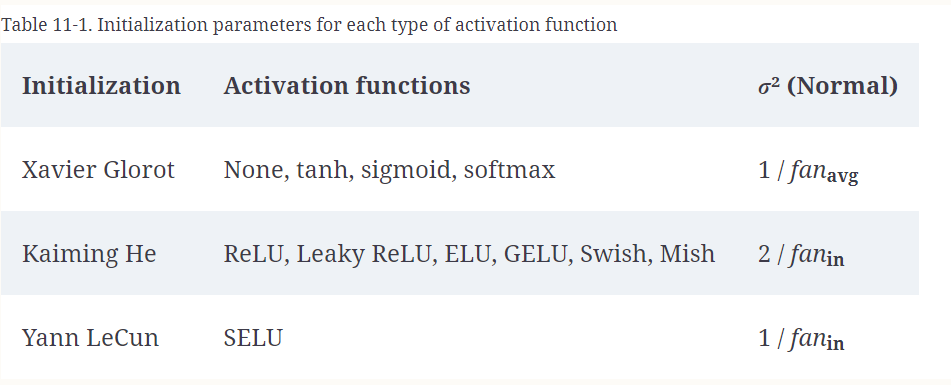

In [3]:
from IPython.display import Image
Image(filename='./images/mls4_table.png')

By default, Keras uses `Glorot initialization` with a uniform distribution. When creating a layer, we can change this to He initialization by setting `kernel_initializer="he_uniform"` or `kernel_initializer="he_normal"`. Alternatively, we can obtain any of the initializations listed in the above Table and more using the `VarianceScaling` initializer. For example, if we want `He initialization` with a uniform distribution and based on $fan_{\mathbf{avg}}$ (rather than $fan_{\mathbf{in}}$), we can use the following code:

In [4]:
import tensorflow as tf

he_avg_init = tf.keras.initializers.VarianceScaling(scale=2., mode="fan_avg",
                                                    distribution="uniform")
dense = tf.keras.layers.Dense(50, activation="sigmoid",
                              kernel_initializer=he_avg_init)

c:\Users\16044\anaconda3\envs\tensorflow\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Better Activation Functions

`ReLU` ($\mathbf{ReLU} (z) = \mathrm{max} (0, z)$) is a better activation function than `sigmoid`, mostly because it does not saturate for positive values, and also because it is very fast to compute. Unfortunately, the `ReLU` activation function is not perfect. It suffers from a problem known as the `dying ReLUs`: during training, some neurons effectively “die,” meaning they stop outputting anything other than 0. This is because the inputs in those neurons are negative. When this happens, Gradient Descent does not affect it anymore because the gradient of the `ReLU` function is zero when its input is negative.

#### Leaky ReLU

To solve this problem, we can use a variant of the `ReLU` function, such as the `leaky ReLU`: $$ \mathbf{LeakyReLU}_{\alpha} (z) = \mathrm{max} (\alpha z, z) $$

The hyperparameter $\alpha$ defines how much the function “leaks”: it is the slope of the function for $z < 0$. Having a slope for $z < 0$ ensures that `leaky ReLUs` never die.⁠

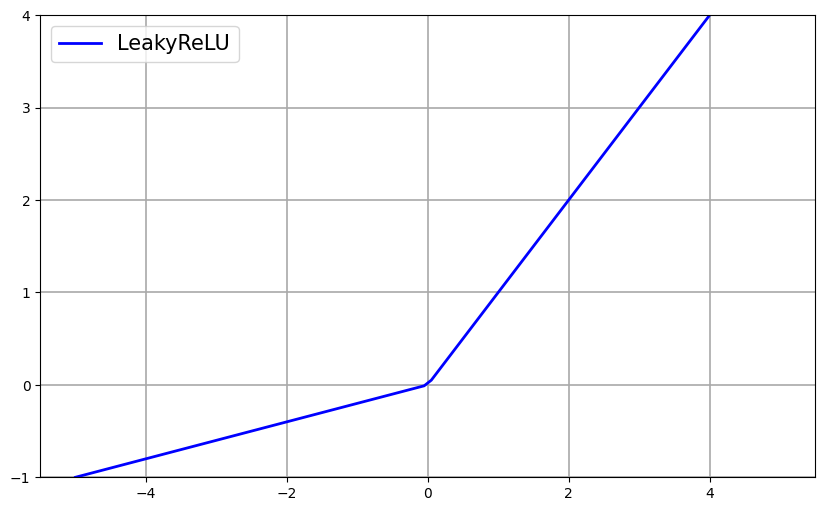

In [5]:
def LeakyReLU(z, alpha):
    return np.maximum(alpha*z, z)

z = np.linspace(-5, 5, 100)

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(z, LeakyReLU(z, 0.2), color='blue', linestyle='-', label='LeakyReLU', linewidth=2)

ax.grid(linewidth=1.2, color='darkgrey')
ax.legend(fontsize=15)

plt.ylim(-1, 4)

plt.show()

There are some variants of `Leaky ReLU` namely `randomized leaky ReLU (RReLU)`, where $\alpha$ is picked randomly in a given range during training and is fixed to an average value during testing. The other variant is `parametric leaky ReLU (PReLU)`, where $\alpha$ is authorized to be learned during training.

Keras includes the classes `LeakyReLU` and `PReLU` in the `tf.keras.layers` package. Just like for other `ReLU` variants, `He initialization`, should be used.

In [6]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)  # defaults to alpha=0.3

dense = tf.keras.layers.Dense(50, activation=leaky_relu,
                              kernel_initializer="he_normal")

`ReLU`, `Leaky ReLU`, and `PReLU` all suffer from the fact that they are not *smooth* functions: their derivatives abruptly change (at $z = 0$). This sort of discontinuity can make `Gradient Descent` *bounce* around the optimum, and slow down convergence. So now we will look at *smooth* variants of the `ReLU` activation function, starting with `ELU` and `SELU`.

#### ELU and SELU

**ELU activation function:** $$ \mathbf{ELU}_{\alpha} (z) = \begin{cases} \alpha (e^z -1 ) & \text{ if } z < 0 \\ z & \text{ if } z\ge 0 \end{cases}  $$

The `ELU` activation function looks a lot like the `ReLU` function, with a few major differences:

- It takes on negative values when $z < 0$, which allows the unit to have an average output closer to $0$ and helps alleviate the vanishing gradients problem. The hyperparameter $\alpha$ defines the opposite of the value that the `ELU` function approaches when $z$ is a large negative number. It is usually set to $1$, but can be tweaked like any hyperparameter.

- It has a nonzero gradient for $z < 0$, which avoids the dead neurons problem.

- If $\alpha = 1 $ then the function is smooth everywhere, including around $z = 0$, which helps speed up Gradient Descent since it does not bounce as much to the left and right of $z = 0$.

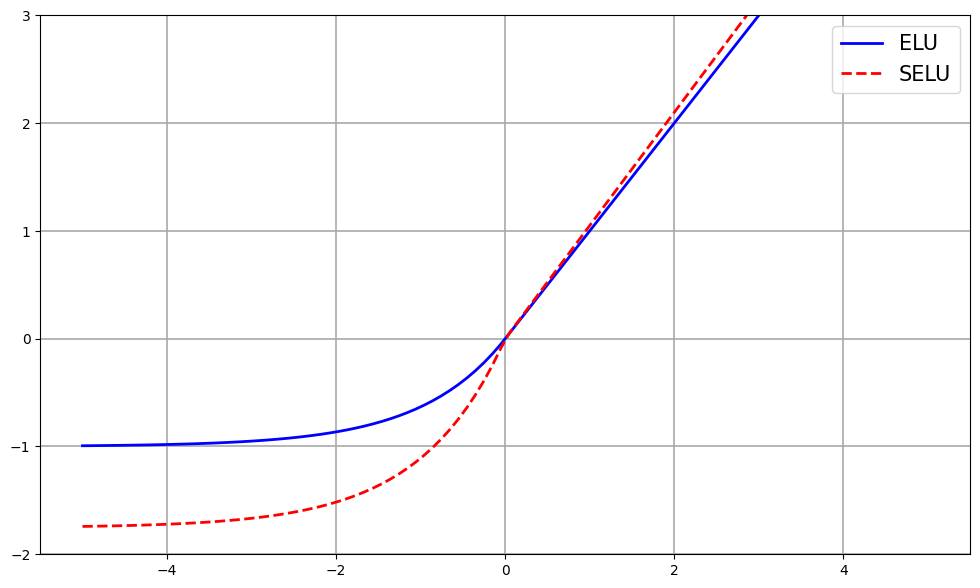

In [7]:
def ELU(z, alpha):
    if z<0:
        return alpha * (np.exp(z)-1)
    else: 
        return z

def SELU(z):
    return 1.05 * ELU(z, 1.67)

z = np.linspace(-5, 5, 100)
elu = [ELU(x, 1.) for x in z]
selu = [SELU(x) for x in z]


fig, ax = plt.subplots(figsize=(12,7))

ax.plot(z, elu, color='blue', linestyle='-', label='ELU', linewidth=2)
ax.plot(z, selu, color='red', linestyle='--', label='SELU', linewidth=2)

ax.grid(linewidth=1.2, color='darkgrey')
ax.legend(fontsize=15)

plt.ylim(-2, 3)

plt.show()